# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=NumbaPerformanceWarning)

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import anndata
import scanpy as sc
import scanpy_scripts as ss

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
ss.lib.set_figsize((4, 4))
expr_cmap = ss.lib.expression_colormap()

# Load data

In [2]:
h5ads = [
    'human_gingiva.processed.cellxgene.h5ad',
    'human_salivary_gland.processed.h5ad',
]

In [3]:
gv_ad, sg_ad = [sc.read(h5ad) for h5ad in h5ads]

# Integrate

## Down-sample

In [4]:
ads = [ss.lib.subsample(gv_ad, 1, groupby='annot1', min_n=100, max_n=500), ss.lib.subsample(sg_ad, 1, groupby='annot1', min_n=100, max_n=500)]

## Integrate

In [5]:
pooled = ss.lib.integrate(
    ads,
    ad_types=['raw_norm', 'raw_norm'],
    batches=['batch', 'batch'],
    ad_prefices=['gv', 'sg'],
    annotations=['annot1', 'annot1'],
    n_hvg=2000,
    join='outer',
    pool_only=True
)

In [6]:
pooled1 = ss.lib.simple_default_pipeline(
    pooled.copy(), post_norm_only=True, do_clustering=False,
    batch=['dataset', 'batch'], batch_method='harmony',
    hvg_kw={'by_batch': ('batch', 1), 'n_hvg': 2000},
    pca_kw={'remove_genes': ('mito', 'ribo')},
)

In [7]:
pooled1.obsm['X_umap'] = pooled1.obsm['X_umap_hm']

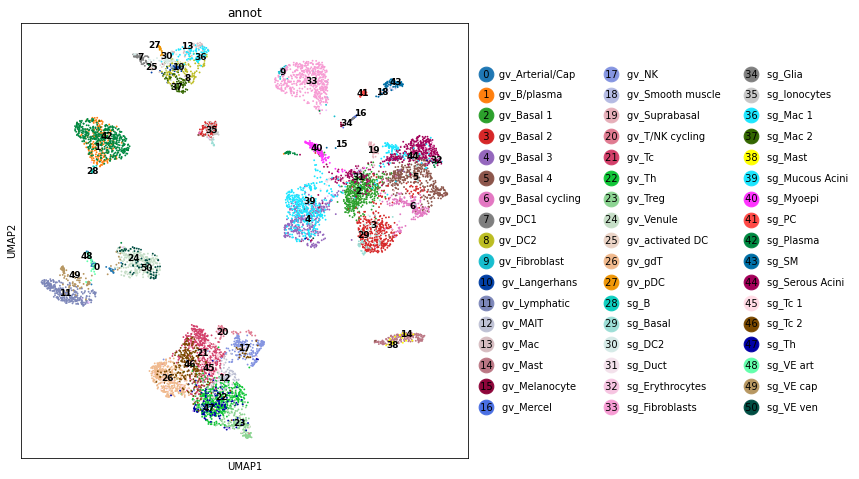

In [8]:
ss.lib.plot_embedding(pooled1, basis='umap', groupby='annot', figsize=(8, 8));

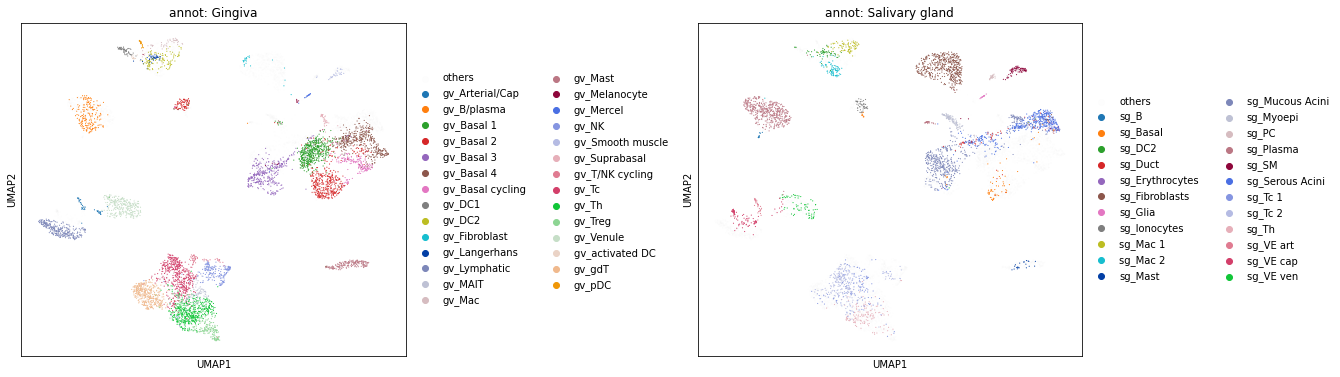

In [9]:
ss.lib.highlight(pooled1, basis='umap', groupby='annot', groups={
    'Gingiva': pd.Series(pooled1.obs.annot.cat.categories).loc[lambda x: x.str.startswith('gv')].to_list(),
    'Salivary gland': pd.Series(pooled1.obs.annot.cat.categories).loc[lambda x: x.str.startswith('sg')].to_list(),
}, wspace=0.6, figsize=(6, 6), size=5)

## Cluster and joint annotation

In [10]:
markers = [
    'KRT15', 'PIGR', 'FOXI1', 'AIF1', 'ACTA2', 'PECAM1', 'COL3A1', 'NRXN1', 'CD3D', 'MS4A1', 'IGHA1', 'TPSB2', 'MKI67'
]

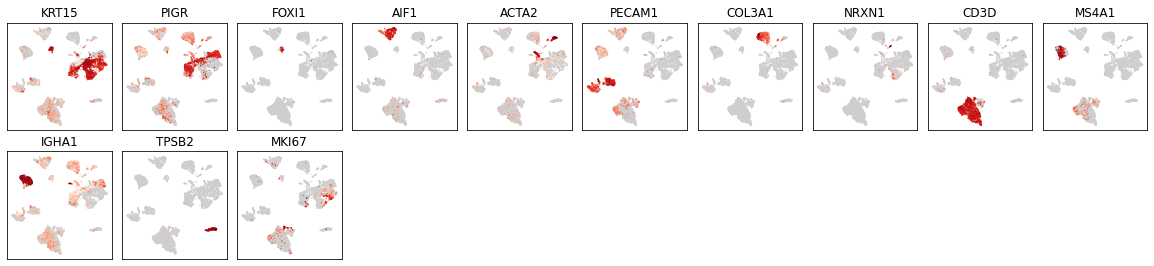

In [11]:
ss.lib.plot_genes(pooled1, basis='umap_hm', genes=markers, color_map=expr_cmap, size=5);

In [12]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', resolution=[0.9], key_added='hm')

['leiden_hm_r0_9']

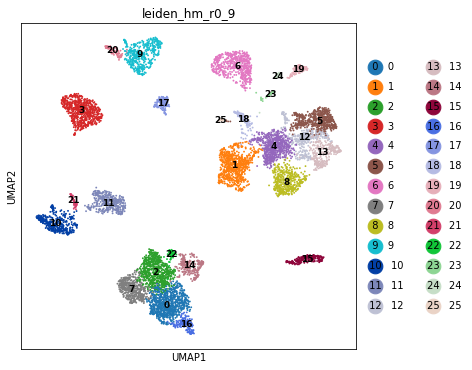

In [13]:
ss.lib.plot_embedding(pooled1, basis='umap', groupby='leiden_hm_r0_9', figsize=(6, 6));

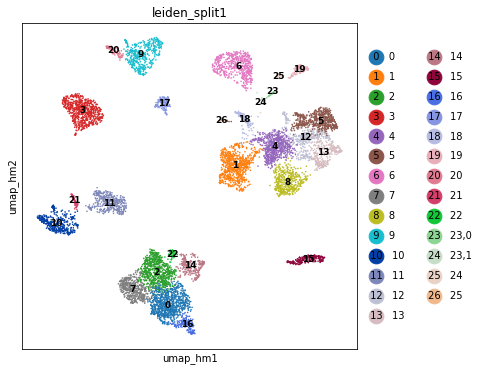

In [14]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', restrict_to=('leiden_hm_r0_9', ['23']), resolution=0.1, key_added='split1')
ss.lib.plot_embedding(pooled1, basis='umap_hm', groupby='leiden_split1', size=10, figsize=(6, 6));

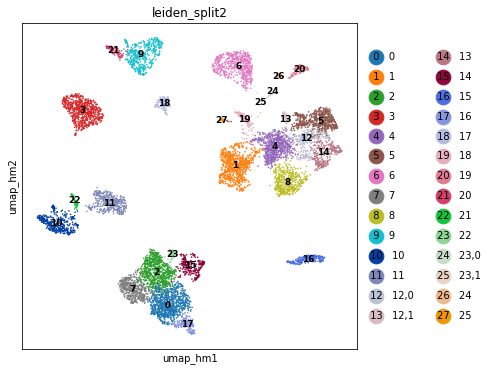

In [15]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', restrict_to=('leiden_split1', ['12']), resolution=0.07, key_added='split2')
ss.lib.plot_embedding(pooled1, basis='umap_hm', groupby='leiden_split2', size=10, figsize=(6, 6));

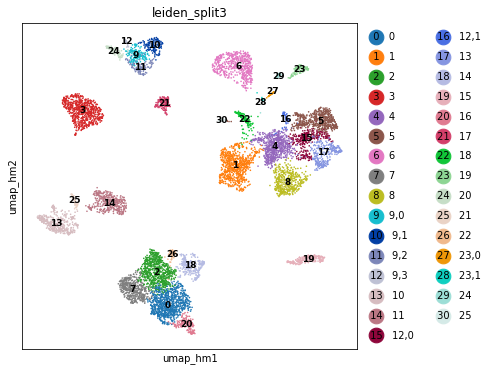

In [16]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', restrict_to=('leiden_split2', ['9']), resolution=0.2, key_added='split3')
ss.lib.plot_embedding(pooled1, basis='umap_hm', groupby='leiden_split3', size=10, figsize=(6, 6));

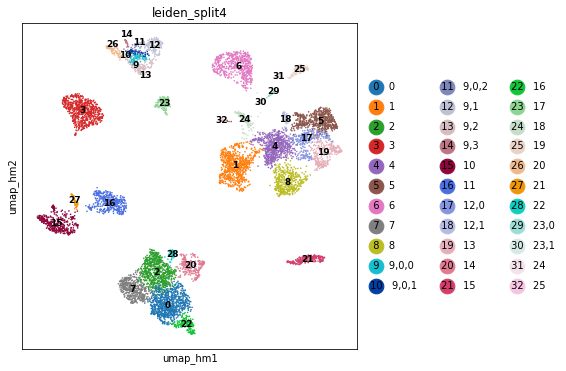

In [17]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', restrict_to=('leiden_split3', ['9,0']), resolution=0.3, key_added='split4')
ss.lib.plot_embedding(pooled1, basis='umap_hm', groupby='leiden_split4', size=10, figsize=(6, 6));

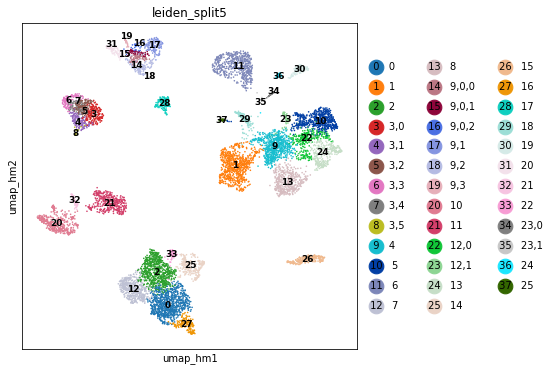

In [18]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', restrict_to=('leiden_split4', ['3']), resolution=0.6, key_added='split5')
ss.lib.plot_embedding(pooled1, basis='umap_hm', groupby='leiden_split5', size=10, figsize=(6, 6));

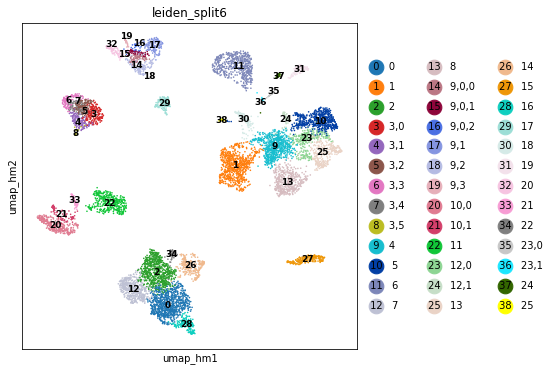

In [19]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', restrict_to=('leiden_split5', ['10']), resolution=0.2, key_added='split6')
ss.lib.plot_embedding(pooled1, basis='umap_hm', groupby='leiden_split6', size=10, figsize=(6, 6));

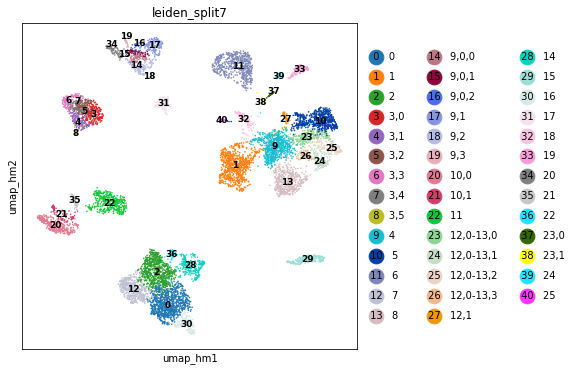

In [20]:
ss.lib.leiden(pooled1, use_graph='neighbors_hm', restrict_to=('leiden_split6', ['12,0', '13']), resolution=0.2, key_added='split7')
ss.lib.plot_embedding(pooled1, basis='umap_hm', groupby='leiden_split7', size=10, figsize=(6, 6));

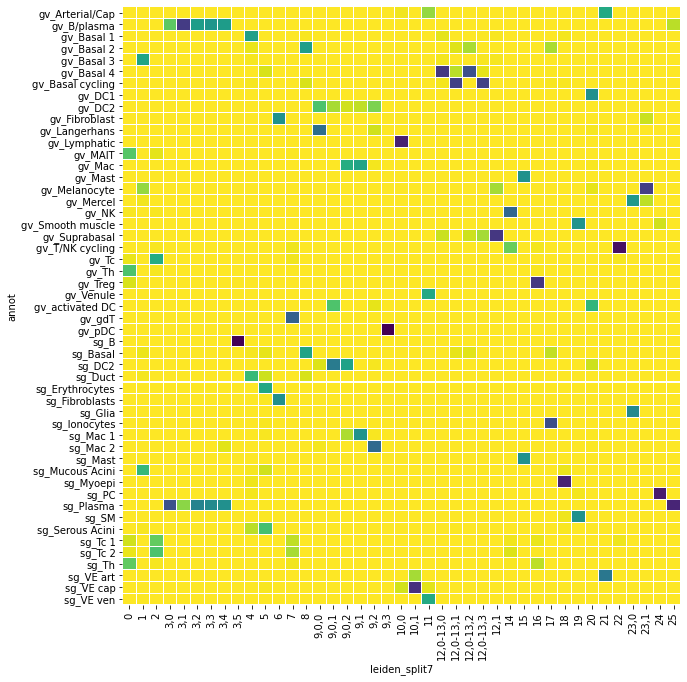

In [21]:
ss.lib.cross_table(pooled1, 'annot', 'leiden_split7', normalise='xy', plot=True, figsize=(10, 11), cbar=False);

In [22]:
pooled1.obs['joint_annot'] = ss.lib.regroup(pooled1, groupby='leiden_split7', regroups={
    'Basal 1': '4',
    'Basal 2': ['12,0-13,0', '12,0-13,2'],
    'Basal 3': '8',
    'Basal cycling': ['12,0-13,1', '12,0-13,3'],
    'Suprabasal': '12,1',
    'Serous': '5',
    'Mucous': '1',
    'Myoepithelium': '18',
    'Ionocyte': '17',
    'Arterial': '21',
    'Capillary': '10,1',
    'Postcapillary venule': '11',
    'Lymphatic endothelium': '10,0',
    'Fibroblast': '6',
    'Pericyte': '24',
    'Smooth muscle': '19',
    'Melanocyte': '23,1',
    'Mercel/Glial': '23,0',
    'Tc': '2',
    'Th': '0',
    'Treg': '16',
    'gdT': '7',
    'NK': '14',
    'T/NK cycling': '22',
    'B': '3,5',
    'Plasma': ['3,0', '3,1', '3,2', '3,3', '3,4', '25'],
    'DC plasmatoid': '9,3',
    'DC1': '20',
    'DC2': '9,0,1',
    'LC': '9,0,0',
    'Macrophage 1': ['9,1', '9,0,2'],
    'Macrophage 2': ['9,2'],
    'Mast': '15',
})

In [23]:
joint_celltypes = pooled1.obs.joint_annot.cat.categories.to_list()
pooled1.obs['joint_annot'] = pooled1.obs.joint_annot.astype(str)
pooled1.obs.loc[pooled1.obs.annot=='sg_Duct', 'joint_annot'] = 'Duct'
pooled1.obs['joint_annot'] = pooled1.obs['joint_annot'].astype('category')
joint_celltypes.insert(joint_celltypes.index('Myoepithelium'), 'Duct')
pooled1.obs.joint_annot.cat.reorder_categories(joint_celltypes, inplace=True)

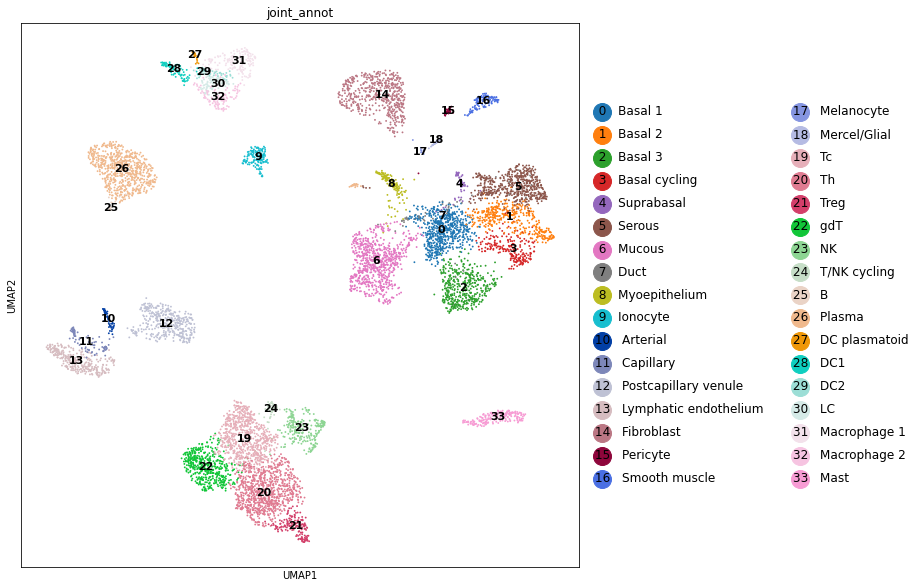

In [24]:
ss.lib.plot_embedding(pooled1, basis='umap', groupby='joint_annot', figsize=(10, 10), legend_fontsize=11);

In [25]:
pooled1.write('human_integrated.processed.joint_annotation.h5ad', compression='gzip')

## Markers

In [26]:
mkst = ss.lib.calc_marker_stats(pooled1, groupby='joint_annot')

In [27]:
mks = ss.lib.filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.05, max_next_frac=0.4, how='and', single=False)

In [28]:
deg = ss.lib.test_markers(pooled1, mks, groupby='joint_annot')

In [29]:
deg1 = deg.loc[lambda x: x.pvals < 0.01].copy()

In [30]:
deg1s = deg1.groupby('cluster', sort=False).apply(
    lambda x: x.sort_values(['frac_diff', 'pvals_adj'], ascending=[False, True])).reset_index(drop=True)

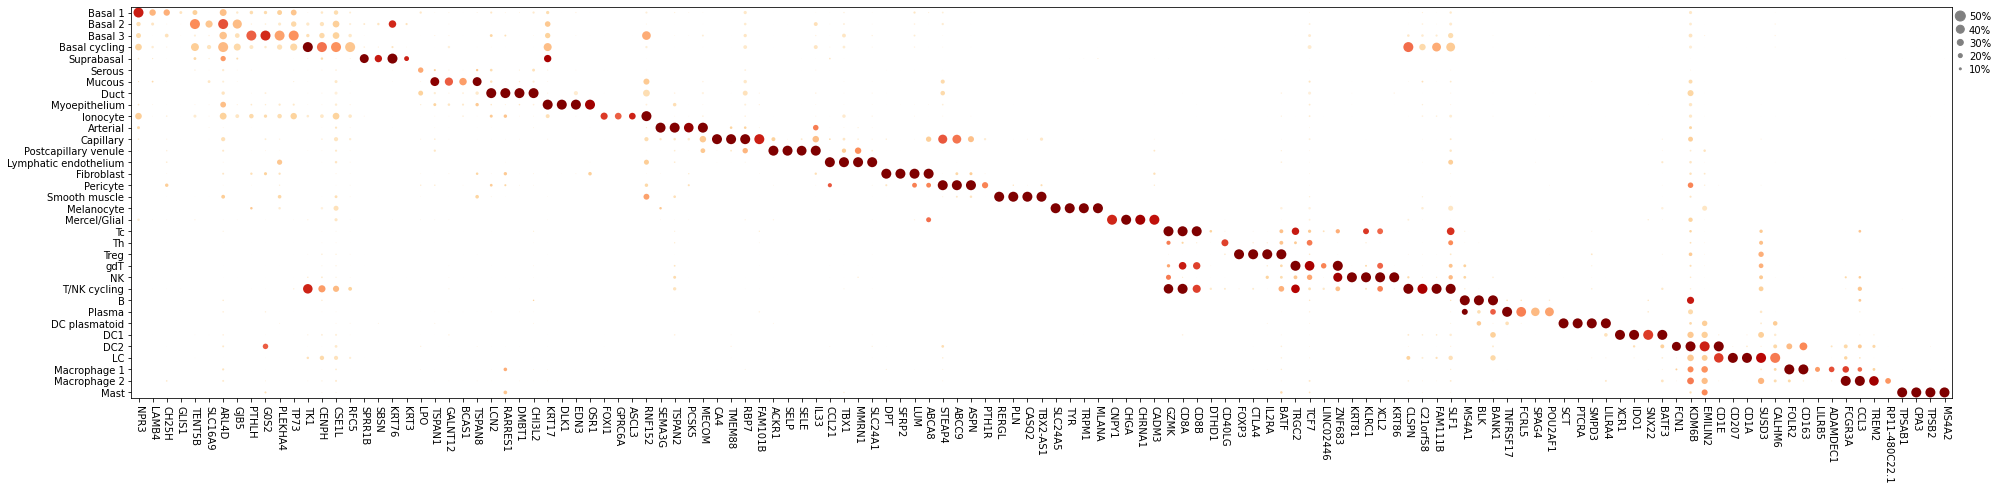

In [31]:
ss.lib.dotplot2(
    pooled1, deg1s.groupby('cluster', sort=False).head(4).genes.to_list(), groupby='joint_annot', color_map='OrRd', swap_axis=True, dot_max=0.5);

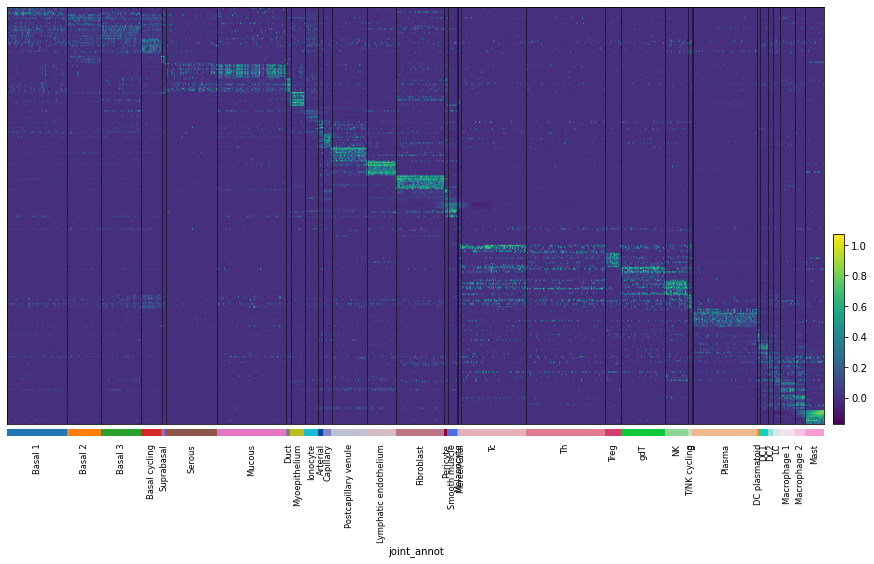

In [32]:
sc.pl.heatmap(
    pooled1, deg1s.groupby('cluster', sort=False).head(10).genes.to_list(),
    groupby='joint_annot', standard_scale='var', swap_axes=True, figsize=(15,8)
);

## SARS-CoV-2 entry factors

In [33]:
covid_markers_human = [
    'ACE2', 'TMPRSS2', 'BSG', 'TFRC', 'CTSL', 'CTSB', 'TMPRSS4', 'TMPRSS11D', 'LY6E',
    'IFITM1', 'IFITM2', 'IFITM3', 'GSK3', 'HNRNPA1', 'FURIN', 'DDX3X', 'MADP1', 'TOP3B',
    'DPP4', 'STGAL4', 'ST3GAL1', 'ST14', 'ANPEP', 'VCP', 'FIIT1', 'IFIT2', 'IFIT3', 'CDHR3',
    'CD209', 'CLEC4G', 'CLEC4M', 'CHMP2A', 'ORF98', 'AP2A2', 'AP2M1', 'TAPT1', 'RHOA',
    'RAB14', 'RAB10', 'NSP7', 'RAB1A', 'ZCRB1'
]

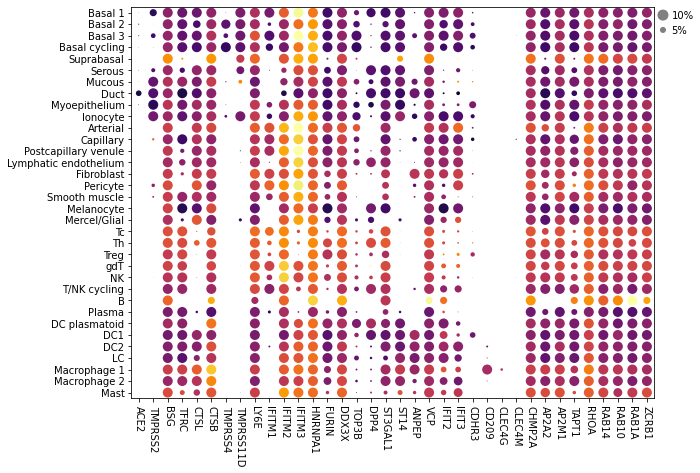

In [34]:
ss.lib.dotplot2(
    pooled1, [g for g in covid_markers_human if g in pooled1.raw.var_names], groupby='joint_annot',
    vmin=0, vmax=3, mean_only_expressed=True, dot_max=0.1, color_map='inferno', swap_axis=True,
);

### Epithelium

In [35]:
k_epi_cells = pooled1.obs.joint_annot.isin(
    ['Basal 1', 'Basal 2', 'Basal 3', 'Basal cycling', 'Duct', 'Suprabasal', 'Serous', 'Mucous', 'Myoepithelium'])

In [36]:
epi_ad = pooled1[k_epi_cells].copy()

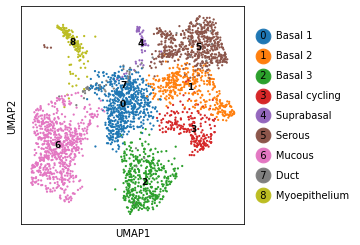

In [37]:
ss.lib.plot_embedding(
    epi_ad, basis='umap', groupby='joint_annot', size=20, title='',
);

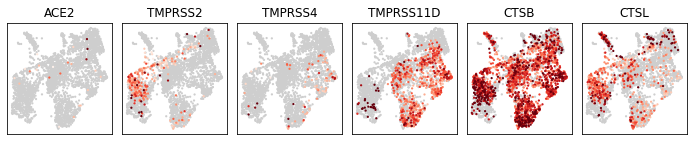

In [38]:
ss.lib.plot_genes(
    epi_ad, basis='umap', genes=['ACE2', 'TMPRSS2', 'TMPRSS4', 'TMPRSS11D', 'CTSB', 'CTSL'],
    color_map=expr_cmap, size=20, vmin=0, vmax=2
);

/home/ubuntu/src/github/nh3/scanpy-scripts/scanpy_scripts/lib/_plot.py:244: RuntimeWarning: invalid value encountered in double_scalars
  avg1 = df.groupby('group')[keys].apply(lambda g: g.min(axis=1).sum() / (((g>0).sum(axis=1)==2)).sum()).fillna(0).values


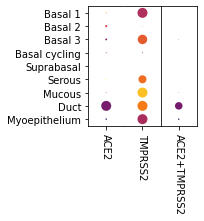

In [39]:
ss.lib.dotplot_combined_coexpression(
    epi_ad, genes=['ACE2', 'TMPRSS2'], groupby='joint_annot', mean_only_expressed=True,
    merge=True, dot_max=0.05, color_map='inferno', vmin=0, vmax=1
)